<a href="https://colab.research.google.com/github/TaeGongKim/tensorflow-developer/blob/main/Natural%20Language%20Processing%20in%20TensorFlow/Exploring_overfitting_in_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [2]:
embedding_dim = 100
max_length = 16
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_size = 16000
test_portion = 0.1

In [3]:
!gdown --id 1wd8KaeCSHxt-nEpMeuHFSNWrDp8joUXJ

Downloading...
From: https://drive.google.com/uc?id=1wd8KaeCSHxt-nEpMeuHFSNWrDp8joUXJ
To: /content/training_cleaned.csv
100% 239M/239M [00:01<00:00, 170MB/s]


In [4]:
num_sentences = 0
corpus = []

with open('./training_cleaned.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter = ',')

  for row in reader:
    list_item = []
    list_item.append(row[5])
    this_label = row[0]

    if this_label == '0':
      list_item.append(0)
    else:
      list_item.append(1)

    num_sentences = num_sentences + 1
    corpus.append(list_item)

# print(list_item)
# output : ['happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H ', 1]

In [5]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [6]:
sentences = []
labels = []
random.shuffle(corpus)

for x in range(training_size):
  sentences.append(corpus[x][0])
  labels.append(corpus[x][1])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size = len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen = max_length, 
                       padding = padding_type, truncating = trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[:split]
training_sequences = padded[split:training_size]
test_labels = labels[:split]
training_labels = labels[split:training_size]

In [7]:
print(vocab_size)
print(word_index['i'])

26470
1


In [8]:
!gdown --id 1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g

Downloading...
From: https://drive.google.com/uc?id=1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g
To: /content/glove.6B.100d.txt
100% 347M/347M [00:02<00:00, 170MB/s]


In [9]:
embeddings_index = {}

with open('./glove.6B.100d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs


embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))

for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embeddings_matrix[i] = embedding_vector

In [10]:
print(len(embeddings_matrix))

26471


In [11]:
model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size + 1, embedding_dim, input_length = max_length,
                                weights = [embeddings_matrix], trainable = False),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv1D(64, 5, activation = 'relu'),
      tf.keras.layers.MaxPooling1D(pool_size = 4),
      tf.keras.layers.LSTM(64),
      tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           2647100   
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,712,253
Trainable params: 65,153
Non-trainable params: 2,647,100
_________________________________________

In [12]:
num_epochs = 50

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels,
                    epochs = num_epochs,
                    validation_data = (testing_padded, testing_labels),
                    verbose = 2)

Epoch 1/50
450/450 - 34s - loss: 0.6356 - accuracy: 0.6333 - val_loss: 0.5617 - val_accuracy: 0.7081
Epoch 2/50
450/450 - 2s - loss: 0.5727 - accuracy: 0.6981 - val_loss: 0.5388 - val_accuracy: 0.7394
Epoch 3/50
450/450 - 2s - loss: 0.5463 - accuracy: 0.7184 - val_loss: 0.5416 - val_accuracy: 0.7244
Epoch 4/50
450/450 - 2s - loss: 0.5147 - accuracy: 0.7425 - val_loss: 0.5576 - val_accuracy: 0.7156
Epoch 5/50
450/450 - 2s - loss: 0.4837 - accuracy: 0.7619 - val_loss: 0.5402 - val_accuracy: 0.7344
Epoch 6/50
450/450 - 2s - loss: 0.4554 - accuracy: 0.7819 - val_loss: 0.5447 - val_accuracy: 0.7325
Epoch 7/50
450/450 - 2s - loss: 0.4344 - accuracy: 0.7928 - val_loss: 0.5607 - val_accuracy: 0.7325
Epoch 8/50
450/450 - 2s - loss: 0.4063 - accuracy: 0.8106 - val_loss: 0.5723 - val_accuracy: 0.7275
Epoch 9/50
450/450 - 2s - loss: 0.3888 - accuracy: 0.8208 - val_loss: 0.5981 - val_accuracy: 0.7200
Epoch 10/50
450/450 - 2s - loss: 0.3680 - accuracy: 0.8314 - val_loss: 0.6319 - val_accuracy: 0.726

<Figure size 432x288 with 0 Axes>

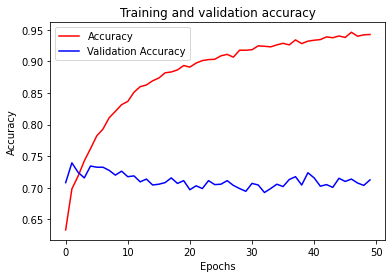

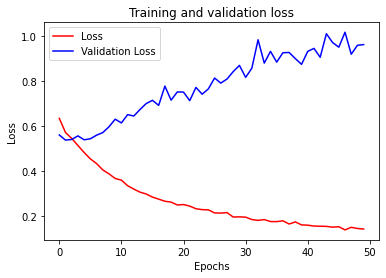

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!